In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import tensorflow as tf
from time import time
import sys
from dataLoader import loadData
import os

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 5.011397123336792 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os

In [13]:
lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 0 #change
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-3 # constant for L2 penalty (diversity)

In [14]:
train = tr.copy()

In [15]:
if torch.cuda.is_available()==True:
    device="cuda"
else:
    device ="cpu"

In [16]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())/(fake == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD().to(device)
netG = NetG().to(device)
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [17]:
one = torch.FloatTensor([1]).to(device)
mone = (one * -1).to(device)

In [18]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [19]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [20]:
get_random_batch(train, batch_size=batch_size).shape

(64, 3706)

In [21]:
train = torch.autograd.Variable(torch.Tensor(train))

In [22]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [23]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
for epoch in range(0):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            torch.save(netG.state_dict(), './netG-1m')
            torch.save(netD.state_dict(), './netD-1m')
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

In [24]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

In [25]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG(noisev)

In [27]:
fake.shape

torch.Size([6040, 3706])

In [28]:
fake = np.around(fake.detach().cpu().numpy())

In [29]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [30]:
fake = fake * (fake <= 5).astype(int)

In [31]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1787729 226310
4 634312 348971
3 94038 261197
2 2991 107557
1 5 56174
0 19865165 21384031


In [32]:
train > 3 

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [33]:
get_sparsity(train > 3)

8.934857739195076e-06

In [34]:
(train[0,:] > 3).sum()

tensor(43)

In [35]:
train

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])

In [36]:
train = torch.Tensor(tr.copy()).to(device)

In [37]:
get_sparsity(train.cpu().numpy())

4.021525859265269

In [38]:
train > 3

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [39]:
zero_mask = (train == 0).to(device).float()

In [40]:
positive_feedback_mask = (train > 3).to(device).float()

In [41]:
negative_feedback_mask = ((train < 4).to(device).float() * (1 - zero_mask)).to(device).float()

In [42]:
((positive_feedback_mask + negative_feedback_mask) != zero_mask).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

In [43]:
get_sparsity(negative_feedback_mask.cpu().numpy())

1.7090908603553212

In [296]:
class denoising_autoencoder(nn.Module):
    def __init__(self, n_users, input_size, z=512):
        super(denoising_autoencoder, self).__init__()
        
#         self.V = torch.FloatTensor(z).to(device)
        self.V = torch.FloatTensor(n_users, z).to(device)
        self.b = torch.FloatTensor(n_users, 1).to(device)
        self.b_shtrix = torch.FloatTensor(n_users, 1).to(device)
    
        self.encoder = nn.Linear(input_size, z)
        self.decoder = nn.Linear(z, input_size)
        
        torch.nn.init.xavier_uniform_(self.encoder.weight)
        torch.nn.init.xavier_uniform_(self.encoder.weight)
        
#         torch.nn.init.xavier_uniform(self.V)
#         torch.nn.init.xavier_uniform(self.b.weight)
#         torch.nn.init.xavier_uniform(self.b_shtrix.weight)

#         self.encoder=nn.Sequential(
#                       nn.Linear(input_size, 1024),
#                       nn.ReLU(),
#                       nn.Linear(1024,512),
#                       nn.ReLU(),
#                       nn.Linear(512, z),
# #                       nn.Sigmoid()
#                       )

#         self.decoder=nn.Sequential(
#                       nn.Linear(z, 512),
#                       nn.ReLU(),
#                       nn.Linear(512, 1024),
#                       nn.ReLU(),
#                       nn.Linear(1024, input_size),
# #                       nn.Sigmoid(),
#                       )
 
    def forward(self, x, i):
        z = self.encoder(x)
#         print(z.t().shape, x.shape, self.V.shape, self.V[i, :].shape)
#         torch.Size([32, 64]) torch.Size([64, 3706]) torch.Size([6040, 32]) torch.Size([64, 32])
# #         torch.Size([64, 32]) torch.Size([64, 3706]) torch.Size([3706])
#         print(self.V)
#         print(z.t + self.V)
#         print(self.b[i, :].shape, z.shape, self.V[i, :].shape)
        z = z + self.V[i, :] + self.b[i, :] 
#         z = z + self.V[i, :]
        z = torch.nn.functional.tanh(z)
#         print(z)
        x = self.decoder(z)
#     torch.Size([64, 3706]) torch.Size([64, 32]) torch.Size([64, 32])
#         print(x.shape, z.shape, self.b_shtrix[i, :].shape)
#         print(x.t().shape, self.b_shtrix[i, :].shape)
        x = x + self.b_shtrix[i, :]
    
#         return x
    
        return torch.nn.functional.sigmoid(x)

In [297]:
torch.FloatTensor(10, 32).shape

torch.Size([10, 32])

In [298]:
model = denoising_autoencoder(input_size=train[0,:].shape[0], n_users=train.shape[0]).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

In [299]:
# model

In [300]:
def get_random_masked_batch(mat, batch_size = 32, p=0.5):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    orig = mat[rand_rows].clone()
    corrupted = mat[rand_rows].clone()
    mask_arr = torch.FloatTensor((np.random.rand(orig.shape[0], orig.shape[1]) > p)).to(device)

    return orig, corrupted*mask_arr, rand_rows

orig, masked, _ = get_random_masked_batch(negative_feedback_mask)

In [301]:
get_sparsity(orig.cpu().numpy())

2.296107663248786

In [302]:
get_sparsity(masked.cpu().numpy())

1.1459457636265515

In [303]:
get_sparsity(torch.nn.functional.dropout(masked, training=False).cpu().numpy())

1.1459457636265515

In [304]:
# torch.nn.functional.dropout(orig, training=False)

In [ ]:
losslist = []
model.train()
def train_den_ae(mat,epochs= 400,steps_per_epoch = 300, _unsqueeze=True):
#     epochs = 120
    # l = len(trainloader)
    # l = 120
#     losslist = []
    epochloss = 0
    running_loss = 0
    steps_per_epoch = 100

    for epoch in range(epochs):

        print("Entering Epoch: ", epoch)
        for i in range(steps_per_epoch):
            orig, masked, idxs = get_random_masked_batch(mat, batch_size=batch_size, p=0.25)

            #-----------------Forward Pass----------------------
            if _unsqueeze:
                masked = masked.unsqueeze(2)
            output = model(masked, idxs)
#             print((output >1).all())
#             print((orig >1).all())
#             print(output[0,1:20])
#             print(masked[0,1:20])
#             print(orig.shape, output.shape)
            loss = criterion(output, orig)
            #-----------------Backward Pass---------------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #         running_loss += loss.item()
    #         epochloss += loss.item()
    #         #-----------------Log-------------------------------
    #         losslist.append(running_loss/l)
    #         running_loss=0
    #     print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
            if i%10 == 0:
                running_loss += loss.item()
                epochloss += loss.item()
                #-----------------Log-------------------------------
                losslist.append(running_loss/steps_per_epoch)
                running_loss=0
                print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
                
train_den_ae(negative_feedback_mask, _unsqueeze=False)

Entering Epoch:  0
======> epoch: 0/400, Loss:0.5000854134559631
======> epoch: 0/400, Loss:0.3810594975948334
======> epoch: 0/400, Loss:0.29062819480895996
======> epoch: 0/400, Loss:0.2653268873691559
======> epoch: 0/400, Loss:0.22323191165924072
======> epoch: 0/400, Loss:0.2283015251159668
======> epoch: 0/400, Loss:0.1793147325515747
======> epoch: 0/400, Loss:0.14210015535354614
======> epoch: 0/400, Loss:0.145160973072052
======> epoch: 0/400, Loss:0.12610886991024017
Entering Epoch:  1
======> epoch: 1/400, Loss:0.15251320600509644
======> epoch: 1/400, Loss:0.14511314034461975
======> epoch: 1/400, Loss:0.11607272922992706
======> epoch: 1/400, Loss:0.13640323281288147
======> epoch: 1/400, Loss:0.11901631951332092
======> epoch: 1/400, Loss:0.09775959700345993
======> epoch: 1/400, Loss:0.10340878367424011
======> epoch: 1/400, Loss:0.10527709126472473
======> epoch: 1/400, Loss:0.08812107145786285
======> epoch: 1/400, Loss:0.07319626212120056
Entering Epoch:  2
======> ep

======> epoch: 16/400, Loss:0.02950158342719078
======> epoch: 16/400, Loss:0.026425769552588463
======> epoch: 16/400, Loss:0.025863241404294968
======> epoch: 16/400, Loss:0.02730412222445011
======> epoch: 16/400, Loss:0.029536927118897438
======> epoch: 16/400, Loss:0.02263629250228405
Entering Epoch:  17
======> epoch: 17/400, Loss:0.029974181205034256
======> epoch: 17/400, Loss:0.020587721839547157
======> epoch: 17/400, Loss:0.022550029680132866
======> epoch: 17/400, Loss:0.02379276230931282
======> epoch: 17/400, Loss:0.02510671503841877
======> epoch: 17/400, Loss:0.026822732761502266
======> epoch: 17/400, Loss:0.025463605299592018
======> epoch: 17/400, Loss:0.022749627009034157
======> epoch: 17/400, Loss:0.02617516554892063
======> epoch: 17/400, Loss:0.021802935749292374
Entering Epoch:  18
======> epoch: 18/400, Loss:0.026199379935860634
======> epoch: 18/400, Loss:0.02502358704805374
======> epoch: 18/400, Loss:0.01830233260989189
======> epoch: 18/400, Loss:0.0288374

======> epoch: 32/400, Loss:0.017857424914836884
======> epoch: 32/400, Loss:0.026990648359060287
======> epoch: 32/400, Loss:0.019545577466487885
======> epoch: 32/400, Loss:0.02297106198966503
======> epoch: 32/400, Loss:0.023300353437662125
Entering Epoch:  33
======> epoch: 33/400, Loss:0.018538210541009903
======> epoch: 33/400, Loss:0.02129737101495266
======> epoch: 33/400, Loss:0.02286544442176819
======> epoch: 33/400, Loss:0.016625847667455673
======> epoch: 33/400, Loss:0.020380644127726555
======> epoch: 33/400, Loss:0.013837490230798721
======> epoch: 33/400, Loss:0.019706420600414276
======> epoch: 33/400, Loss:0.016730381175875664
======> epoch: 33/400, Loss:0.015835268422961235
======> epoch: 33/400, Loss:0.02181277796626091
Entering Epoch:  34
======> epoch: 34/400, Loss:0.019986776635050774
======> epoch: 34/400, Loss:0.020810186862945557
======> epoch: 34/400, Loss:0.024726631119847298
======> epoch: 34/400, Loss:0.016817623749375343
======> epoch: 34/400, Loss:0.016

======> epoch: 48/400, Loss:0.020661883056163788
======> epoch: 48/400, Loss:0.01754726655781269
======> epoch: 48/400, Loss:0.021356675773859024
======> epoch: 48/400, Loss:0.0193482618778944
Entering Epoch:  49
======> epoch: 49/400, Loss:0.01975620537996292
======> epoch: 49/400, Loss:0.01974296197295189
======> epoch: 49/400, Loss:0.014862345531582832
======> epoch: 49/400, Loss:0.01541930716484785
======> epoch: 49/400, Loss:0.021488787606358528
======> epoch: 49/400, Loss:0.01629195734858513
======> epoch: 49/400, Loss:0.018661094829440117
======> epoch: 49/400, Loss:0.01970416121184826
======> epoch: 49/400, Loss:0.019727010279893875
======> epoch: 49/400, Loss:0.015828795731067657
Entering Epoch:  50
======> epoch: 50/400, Loss:0.01853027008473873
======> epoch: 50/400, Loss:0.016844268888235092
======> epoch: 50/400, Loss:0.022691182792186737
======> epoch: 50/400, Loss:0.021857349202036858
======> epoch: 50/400, Loss:0.015884224325418472
======> epoch: 50/400, Loss:0.01853015

======> epoch: 64/400, Loss:0.018535686656832695
======> epoch: 64/400, Loss:0.013869349844753742
======> epoch: 64/400, Loss:0.016330722719430923
Entering Epoch:  65
======> epoch: 65/400, Loss:0.022015321999788284
======> epoch: 65/400, Loss:0.01525786705315113
======> epoch: 65/400, Loss:0.019906239584088326
======> epoch: 65/400, Loss:0.015927156433463097
======> epoch: 65/400, Loss:0.020155180245637894
======> epoch: 65/400, Loss:0.019876394420862198
======> epoch: 65/400, Loss:0.01913352683186531
======> epoch: 65/400, Loss:0.019365763291716576
======> epoch: 65/400, Loss:0.017134789377450943
======> epoch: 65/400, Loss:0.015120752155780792
Entering Epoch:  66
======> epoch: 66/400, Loss:0.021307317540049553
======> epoch: 66/400, Loss:0.022595297545194626
======> epoch: 66/400, Loss:0.02034151367843151
======> epoch: 66/400, Loss:0.015959786251187325
======> epoch: 66/400, Loss:0.01923551969230175
======> epoch: 66/400, Loss:0.01655387505888939
======> epoch: 66/400, Loss:0.0199

======> epoch: 80/400, Loss:0.017851388081908226
======> epoch: 80/400, Loss:0.014501258730888367
Entering Epoch:  81
======> epoch: 81/400, Loss:0.016386602073907852
======> epoch: 81/400, Loss:0.022988807410001755
======> epoch: 81/400, Loss:0.016930310055613518
======> epoch: 81/400, Loss:0.0154305100440979
======> epoch: 81/400, Loss:0.014631709083914757
======> epoch: 81/400, Loss:0.020216079428792
======> epoch: 81/400, Loss:0.017854023724794388
======> epoch: 81/400, Loss:0.02129402756690979
======> epoch: 81/400, Loss:0.0183247160166502
======> epoch: 81/400, Loss:0.01719151996076107
Entering Epoch:  82
======> epoch: 82/400, Loss:0.019302653148770332
======> epoch: 82/400, Loss:0.020352568477392197
======> epoch: 82/400, Loss:0.01906086690723896
======> epoch: 82/400, Loss:0.021814001724123955
======> epoch: 82/400, Loss:0.015227258205413818
======> epoch: 82/400, Loss:0.017687175422906876
======> epoch: 82/400, Loss:0.01589428074657917
======> epoch: 82/400, Loss:0.0147353252

======> epoch: 96/400, Loss:0.017391296103596687
Entering Epoch:  97
======> epoch: 97/400, Loss:0.016079816967248917
======> epoch: 97/400, Loss:0.02281658910214901
======> epoch: 97/400, Loss:0.023669321089982986
======> epoch: 97/400, Loss:0.02360018715262413
======> epoch: 97/400, Loss:0.022699180990457535
======> epoch: 97/400, Loss:0.01877468451857567
======> epoch: 97/400, Loss:0.019385257735848427
======> epoch: 97/400, Loss:0.012530379928648472
======> epoch: 97/400, Loss:0.015665292739868164
======> epoch: 97/400, Loss:0.014508950524032116
Entering Epoch:  98
======> epoch: 98/400, Loss:0.01882060058414936
======> epoch: 98/400, Loss:0.02447262406349182
======> epoch: 98/400, Loss:0.01904415898025036
======> epoch: 98/400, Loss:0.017113614827394485
======> epoch: 98/400, Loss:0.020751183852553368
======> epoch: 98/400, Loss:0.01208078395575285
======> epoch: 98/400, Loss:0.022310756146907806
======> epoch: 98/400, Loss:0.01675846241414547
======> epoch: 98/400, Loss:0.0142363

======> epoch: 112/400, Loss:0.015319057740271091
======> epoch: 112/400, Loss:0.02404891885817051
======> epoch: 112/400, Loss:0.019610397517681122
Entering Epoch:  113
======> epoch: 113/400, Loss:0.01621892675757408
======> epoch: 113/400, Loss:0.02064918726682663
======> epoch: 113/400, Loss:0.01905568689107895
======> epoch: 113/400, Loss:0.02145419642329216
======> epoch: 113/400, Loss:0.016779504716396332
======> epoch: 113/400, Loss:0.021859413012862206
======> epoch: 113/400, Loss:0.020196007564663887
======> epoch: 113/400, Loss:0.01753128133714199
======> epoch: 113/400, Loss:0.018511217087507248
======> epoch: 113/400, Loss:0.016896337270736694
Entering Epoch:  114
======> epoch: 114/400, Loss:0.015355240553617477
======> epoch: 114/400, Loss:0.01782008819282055
======> epoch: 114/400, Loss:0.015834083780646324
======> epoch: 114/400, Loss:0.022264594212174416
======> epoch: 114/400, Loss:0.02022489719092846
======> epoch: 114/400, Loss:0.014115061610937119
======> epoch: 1

======> epoch: 128/400, Loss:0.020086318254470825
======> epoch: 128/400, Loss:0.0210579764097929
======> epoch: 128/400, Loss:0.018759699538350105
======> epoch: 128/400, Loss:0.013461739756166935
======> epoch: 128/400, Loss:0.015179182402789593
Entering Epoch:  129
======> epoch: 129/400, Loss:0.01689883880317211
======> epoch: 129/400, Loss:0.017024466767907143
======> epoch: 129/400, Loss:0.015964502468705177
======> epoch: 129/400, Loss:0.020581135526299477
======> epoch: 129/400, Loss:0.023015422746539116
======> epoch: 129/400, Loss:0.01483611948788166
======> epoch: 129/400, Loss:0.019798703491687775
======> epoch: 129/400, Loss:0.014778640121221542
======> epoch: 129/400, Loss:0.023955075070261955
======> epoch: 129/400, Loss:0.018813593313097954
Entering Epoch:  130
======> epoch: 130/400, Loss:0.014007956720888615
======> epoch: 130/400, Loss:0.012096203863620758
======> epoch: 130/400, Loss:0.01914568431675434
======> epoch: 130/400, Loss:0.018365491181612015
======> epoch

======> epoch: 144/400, Loss:0.014609549194574356
======> epoch: 144/400, Loss:0.018272720277309418
======> epoch: 144/400, Loss:0.015483234077692032
======> epoch: 144/400, Loss:0.01830294169485569
======> epoch: 144/400, Loss:0.0212271586060524
======> epoch: 144/400, Loss:0.017267093062400818
======> epoch: 144/400, Loss:0.01781364530324936
Entering Epoch:  145
======> epoch: 145/400, Loss:0.02182939648628235
======> epoch: 145/400, Loss:0.02509624883532524
======> epoch: 145/400, Loss:0.018447453156113625
======> epoch: 145/400, Loss:0.01988799497485161
======> epoch: 145/400, Loss:0.01461021788418293
======> epoch: 145/400, Loss:0.021875977516174316
======> epoch: 145/400, Loss:0.01690049283206463
======> epoch: 145/400, Loss:0.023074250668287277
======> epoch: 145/400, Loss:0.01302946638315916
======> epoch: 145/400, Loss:0.015562397427856922
Entering Epoch:  146
======> epoch: 146/400, Loss:0.015055586583912373
======> epoch: 146/400, Loss:0.015044519677758217
======> epoch: 146

======> epoch: 160/400, Loss:0.017594169825315475
======> epoch: 160/400, Loss:0.023464038968086243
======> epoch: 160/400, Loss:0.013467315584421158
======> epoch: 160/400, Loss:0.017054831609129906
======> epoch: 160/400, Loss:0.01706925965845585
======> epoch: 160/400, Loss:0.01846933551132679
======> epoch: 160/400, Loss:0.015451280400156975
======> epoch: 160/400, Loss:0.018298618495464325
======> epoch: 160/400, Loss:0.018885942175984383
Entering Epoch:  161
======> epoch: 161/400, Loss:0.016416043043136597
======> epoch: 161/400, Loss:0.019033338874578476
======> epoch: 161/400, Loss:0.012486433610320091
======> epoch: 161/400, Loss:0.01892702281475067
======> epoch: 161/400, Loss:0.01730101741850376
======> epoch: 161/400, Loss:0.019448483362793922
======> epoch: 161/400, Loss:0.01767205260694027
======> epoch: 161/400, Loss:0.01486187893897295
======> epoch: 161/400, Loss:0.015836115926504135
======> epoch: 161/400, Loss:0.015821240842342377
Entering Epoch:  162
======> epoch:

======> epoch: 175/400, Loss:0.01922120712697506
Entering Epoch:  176
======> epoch: 176/400, Loss:0.02055048570036888
======> epoch: 176/400, Loss:0.016757667064666748
======> epoch: 176/400, Loss:0.020227467641234398
======> epoch: 176/400, Loss:0.01653166115283966
======> epoch: 176/400, Loss:0.015017963014543056
======> epoch: 176/400, Loss:0.01562798209488392
======> epoch: 176/400, Loss:0.020130639895796776
======> epoch: 176/400, Loss:0.019837545230984688
======> epoch: 176/400, Loss:0.023763272911310196
======> epoch: 176/400, Loss:0.014814069494605064
Entering Epoch:  177
======> epoch: 177/400, Loss:0.01704726740717888
======> epoch: 177/400, Loss:0.020217174664139748
======> epoch: 177/400, Loss:0.019396726042032242
======> epoch: 177/400, Loss:0.01904858648777008
======> epoch: 177/400, Loss:0.016904182732105255
======> epoch: 177/400, Loss:0.02484145015478134
======> epoch: 177/400, Loss:0.015157217159867287
======> epoch: 177/400, Loss:0.01720207929611206
======> epoch: 1

======> epoch: 191/400, Loss:0.01544458232820034
======> epoch: 191/400, Loss:0.020079804584383965
======> epoch: 191/400, Loss:0.01818261481821537
Entering Epoch:  192
======> epoch: 192/400, Loss:0.018828144297003746
======> epoch: 192/400, Loss:0.01665521040558815
======> epoch: 192/400, Loss:0.01659887097775936
======> epoch: 192/400, Loss:0.01769600249826908
======> epoch: 192/400, Loss:0.017314983531832695
======> epoch: 192/400, Loss:0.015374178998172283
======> epoch: 192/400, Loss:0.017724713310599327
======> epoch: 192/400, Loss:0.019816264510154724
======> epoch: 192/400, Loss:0.01576368510723114
======> epoch: 192/400, Loss:0.01731846295297146
Entering Epoch:  193
======> epoch: 193/400, Loss:0.014911552891135216
======> epoch: 193/400, Loss:0.015946727246046066
======> epoch: 193/400, Loss:0.01438458077609539
======> epoch: 193/400, Loss:0.015567260794341564
======> epoch: 193/400, Loss:0.02465209737420082
======> epoch: 193/400, Loss:0.01507305633276701
======> epoch: 193

======> epoch: 207/400, Loss:0.01660693995654583
======> epoch: 207/400, Loss:0.019329458475112915
======> epoch: 207/400, Loss:0.020478323101997375
======> epoch: 207/400, Loss:0.020414361730217934
======> epoch: 207/400, Loss:0.0263911671936512
Entering Epoch:  208
======> epoch: 208/400, Loss:0.016764922067523003
======> epoch: 208/400, Loss:0.01571449637413025
======> epoch: 208/400, Loss:0.014770627953112125
======> epoch: 208/400, Loss:0.014626977033913136
======> epoch: 208/400, Loss:0.017276428639888763
======> epoch: 208/400, Loss:0.020729178562760353
======> epoch: 208/400, Loss:0.01901630312204361
======> epoch: 208/400, Loss:0.019039640203118324
======> epoch: 208/400, Loss:0.015808695927262306
======> epoch: 208/400, Loss:0.018474046140909195
Entering Epoch:  209
======> epoch: 209/400, Loss:0.01991916075348854
======> epoch: 209/400, Loss:0.01866711676120758
======> epoch: 209/400, Loss:0.017351016402244568
======> epoch: 209/400, Loss:0.021283989772200584
======> epoch: 

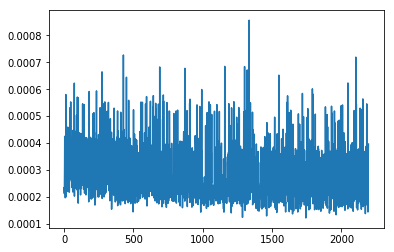

In [211]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [217]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1, p=0.5)

In [218]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

(tensor(7, device='cuda:0'), tensor(2, device='cuda:0'))

In [219]:
orig[0][:100]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [220]:
masked[0][:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [221]:
model.eval()

denoising_autoencoder(
  (encoder): Linear(in_features=3706, out_features=64, bias=True)
  (decoder): Linear(in_features=64, out_features=3706, bias=True)
)

In [222]:
#-----------------Forward Pass----------------------
output = model(masked, _)

C:\Users\David\Anaconda3\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\David\Anaconda3\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [223]:
(output[0] >0.5).sum()

tensor(0, device='cuda:0')

In [208]:
output[0][2000:3000]

tensor([0.0004, 0.0007, 0.0008, 0.0007, 0.0003, 0.0008, 0.0009, 0.0010, 0.0010,
        0.0006, 0.0007, 0.0004, 0.0004, 0.0004, 0.0005, 0.0013, 0.0004, 0.0008,
        0.0010, 0.0005, 0.0011, 0.0007, 0.0007, 0.0010, 0.0007, 0.0012, 0.0011,
        0.0013, 0.0004, 0.0005, 0.0005, 0.0007, 0.0011, 0.0010, 0.0005, 0.0003,
        0.0008, 0.0003, 0.0004, 0.0006, 0.0007, 0.0009, 0.0006, 0.0007, 0.0003,
        0.0006, 0.0007, 0.0005, 0.0004, 0.0005, 0.0007, 0.0008, 0.0003, 0.0007,
        0.0005, 0.0004, 0.0009, 0.0005, 0.0006, 0.0003, 0.0007, 0.0006, 0.0003,
        0.0003, 0.0005, 0.0006, 0.0012, 0.0006, 0.0014, 0.0003, 0.0005, 0.0008,
        0.0009, 0.0005, 0.0014, 0.0005, 0.0010, 0.0003, 0.0011, 0.0004, 0.0006,
        0.0006, 0.0006, 0.0007, 0.0010, 0.0008, 0.0007, 0.0004, 0.0008, 0.0006,
        0.0006, 0.0011, 0.0005, 0.0008, 0.0006, 0.0005, 0.0005, 0.0005, 0.0006,
        0.0005, 0.0006, 0.0010, 0.0007, 0.0009, 0.0004, 0.0006, 0.0013, 0.0012,
        0.0006, 0.0005, 0.0006, 0.0006, 

In [209]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1)

In [ ]:
orig[0][:400]

In [ ]:
masked[0][:400]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked)

In [ ]:
orig[0][:400](orig.round() > 0).sum()

In [ ]:
(masked.round() > 0).sum()

In [ ]:
(output.round() > 0).sum()

In [ ]:
output.round()[0,100:400]

In [ ]:
orig[0,100:400]

In [ ]:
class conv_denoising_autoencoder(nn.Module):

    def __init__(self, inSize,fSize = 32, nz=24):  #sigma is the corruption level
        super(conv_denoising_autoencoder, self).__init__()
        #define layers here

        self.inp_size = inSize
        self.nz = nz
        self.fSize = 32
#         self.imSize = imSize
#         self.sigma = sigma
#         self.multimodalZ = multimodalZ

#         inSize = imSize / ( 2 ** 4)
#         self.inSize = inSize
    
        self.enc1 = nn.Conv1d(self.inp_size, fSize, 5, stride=2, padding=2)
        self.enc2 = nn.Conv1d(fSize, fSize * 2, 5, stride=2, padding=2)
        self.enc3 = nn.Conv1d(fSize * 2, fSize * 4, 5, stride=2, padding=2)
        self.enc4 = nn.Conv1d(fSize * 4, fSize * 8, 5, stride=2, padding=2)
        self.enc5 = nn.Linear(fSize * 8, self.nz)

        self.dec1 = nn.Linear(self.nz, fSize * 8)
        self.dec2 = nn.ConvTranspose1d(fSize * 8, fSize * 4, 3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.ConvTranspose1d(fSize * 4, fSize * 2, 3, stride=2, padding=1, output_padding=1)
        self.dec4 = nn.ConvTranspose1d(fSize * 2, fSize, 3, stride=2, padding=1, output_padding=1)
        self.dec5 = nn.ConvTranspose1d(fSize, 32, 3, stride=2, padding=1, output_padding=1)
        self.last_dec = nn.Linear(32*16, self.inp_size)
        
        self.useCUDA = torch.cuda.is_available()

#     def norm_prior(self, noSamples=25):
#         z = torch.randn(noSamples, self.nz)
#         return z

#     def multi_prior(self, noSamples=25, mode=None):
#         #make a 2D sqrt(nz)-by-sqrt(nz) grid of gaussians
#         num = np.sqrt(self.nz) #no of modes in x and y
#         STD = 1.0
#         modes = np.arange(-num,num)
#         p = np.random.uniform(0, num,(noSamples*2))

#         if mode is None:
#             mu = modes[np.floor(2 * p).astype(int)]
#         else:
#             mu = modes[np.ones((noSamples, 2), dtype=int) * int(mode)]

#         z = torch.Tensor(mu).view(-1,2) + STD * torch.randn(noSamples, 2)
#         return z

    def encode(self, x):
        self.batch_size = x.shape[0]
        #define the encoder here return mu(x) and sigma(x)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = x.view(x.size(0), -1)
        x = self.enc5(x)

        return x

#     def corrupt(self, x):
#         noise = self.sigma * Variable(torch.randn(x.size())).type_as(x)
#         return x + noise

#     def sample_z(self, noSamples=25, mode=None):
#         if not self.multimodalZ:
#             z = self.norm_prior(noSamples=noSamples)
#         else:
#             z = self.multi_prior(noSamples=noSamples, mode=mode)
#         if self.useCUDA:
#             return Variable(z.cuda())
#         else:
#             return Variable(z)

    def decode(self, z):
        #define the decoder here
        z = F.relu(self.dec1(z))
        z = z.unsqueeze(2)
#         print(z.shape)
#         z = z.view(z.size(0), -1, self.inp_size)
        z = F.relu(self.dec2(z))
        z = F.relu(self.dec3(z))
        z = F.relu(self.dec4(z))
        z = F.sigmoid(self.dec5(z))
#         print(z.shape)
#         z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
        z = F.sigmoid(self.last_dec(z.view(self.batch_size, -1)))
    
        return z

    def forward(self, x):
        # the outputs needed for training
#         x_corr = self.corrupt(x)
        z = self.encode(x)
        return self.decode(z)

In [ ]:
model = conv_denoising_autoencoder(train[0,:].shape[0]).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr=0.01, weight_decay=1e-5)

In [ ]:
steps_per_epoch = 500
train_den_ae(negative_feedback_mask, steps_per_epoch=steps_per_epoch, _unsqueeze=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [ ]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=64)

In [ ]:
(orig[0][:400] > 0).sum(), (masked[0][:400] > 0).sum()

In [ ]:
orig[0][:400]

In [ ]:
masked[0][:400]

In [ ]:
#-----------------Forward Pass----------------------
output = model(masked.unsqueeze(2))

In [ ]:
output.shape

In [ ]:
((output[7]).round() >0).sum()

In [ ]:
for i in range(output.shape[0]):
    print(((output[i]).round() >0).sum())

In [ ]:
((output).round() >= 1 ).sum()

In [ ]:
(output).round()[0][2000:3000]

In [ ]:
(output > 0.5).sum()

In [ ]:
!git clone https://github.com/gtshs2/Collaborative-Denoising-Auto-Encoder

In [ ]:
((tr + vr) > 0).sum()

In [277]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [278]:
mask_arr = torch.FloatTensor((np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > 0.35)).to(device)

In [279]:
X = negative_feedback_mask.cpu().numpy()
y = (negative_feedback_mask*mask_arr).cpu().numpy()

In [280]:
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 3706)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,062,074
Trainable params: 4,062,074
Non-trainable params: 0
_________________________________________________

In [281]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.0)

Epoch 1/50
6040/6040 [==============================] - ETA: 8s - loss: 0.090 - ETA: 5s - loss: 0.093 - ETA: 3s - loss: 0.094 - ETA: 3s - loss: 0.093 - ETA: 3s - loss: 0.094 - ETA: 2s - loss: 0.095 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.094 - ETA: 2s - loss: 0.093 - ETA: 2s - loss: 0.092 - ETA: 2s - loss: 0.092 - ETA: 2s - loss: 0.091 - ETA: 2s - loss: 0.091 - ETA: 2s - loss: 0.090 - ETA: 1s - loss: 0.090 - ETA: 1s - loss: 0.090 - ETA: 1s - loss: 0.089 - ETA: 1s - loss: 0.089 - ETA: 1s - loss: 0.088 - ETA: 1s - loss: 0.087 - ETA: 1s - loss: 0.086 - ETA: 1s - loss: 0.085 - ETA: 1s - loss: 0.085 - ETA: 1s - loss: 0.085 - ETA: 1s - loss: 0.084 - ETA: 1s - loss: 0.083 - ETA: 1s - loss: 0.083 - ETA: 1s - loss: 0.082 - ETA: 0s - loss: 0.082 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.080 - ETA: 0s - loss: 0.080 - ETA: 0s - loss: 0.079 - ETA: 0s - loss: 0.079 - ETA: 0s - loss: 0.079 - ETA: 0s - loss: 0.078 - ETA: 0s - loss: 0.078 - ETA: 0s - loss: 0.077 - ETA: 0s 

6040/6040 [==============================] - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.0

Epoch 42/50
6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s

6040/6040 [==============================] - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.0

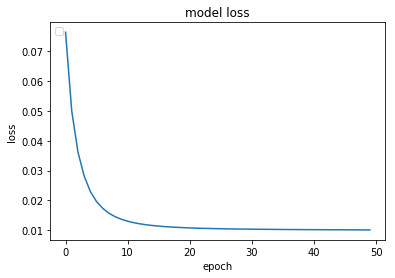

In [282]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [283]:

# Predict new Matrix Interactions, set score zero on visualized games
# new_matrix = model.predict(X) * (X == 0)
new_matrix = model.predict(X)

In [284]:
# # converting the reconstructed matrix back to a Pandas dataframe
# new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
#                                           columns = users_items_matrix_df.columns, 
#                                           index   = users_items_matrix_df.index)
# new_users_items_matrix_df.head()

new_matrix

array([[ 0.00086715, -0.00470824, -0.01668992, ...,  0.00431625,
         0.00356173, -0.01001819],
       [ 0.04016824,  0.01442963,  0.01442499, ...,  0.00142624,
        -0.00103543,  0.01002616],
       [ 0.02150744, -0.00140122,  0.01076992, ..., -0.00505046,
        -0.01062662, -0.00433114],
       ...,
       [-0.00080187,  0.00507312,  0.00350602, ...,  0.00522393,
        -0.00791932, -0.00865945],
       [ 0.04051276, -0.01438116, -0.02296973, ...,  0.00456508,
        -0.01364751,  0.00301851],
       [ 0.1159841 ,  0.04672968,  0.03519899, ...,  0.00532098,
         0.00525959, -0.02073006]], dtype=float32)

In [285]:
(new_matrix>0.5).sum()

2021

In [276]:
(negative_feedback_mask > 0.5).sum()

tensor(382567, device='cuda:0')